## Linear Gaussian Example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from sbi.simulators.linear_gaussian import linear_gaussian
from typing import Union
from sbi.utils import BoxUniform
from torch import eye, ones, zeros
from torch.distributions import MultivariateNormal
from sbi.utils.torchutils import atleast_2d
from sbi.inference import prepare_for_sbi

from loss_calibration.classifier import FeedforwardNN,train
import matplotlib.pyplot as plt
import matplotlib as mpl

copied from : 
https://github.com/mackelab/sbi/blob/7799de5e4bc676ef4a9db304b225503126735f2c/sbi/simulators/linear_gaussian.py#L155

In [3]:
def gt_posterior(
    x_o: torch.Tensor,
    likelihood_shift: torch.Tensor,
    likelihood_cov: torch.Tensor,
    prior: Union[torch.distributions.Uniform, torch.distributions.Independent],
    num_samples: int = 1000,):
    x_o = atleast_2d(x_o)
    num_trials, *_ = x_o.shape
    x_o_mean = x_o.mean(0)
    likelihood_mean = x_o_mean - likelihood_shift

    posterior = MultivariateNormal(
        loc=likelihood_mean, covariance_matrix=1 / num_trials * likelihood_cov
    )

    # skipped: loop to sample and check if within prior

    return posterior

copied from https://github.com/mackelab/sbi/blob/7799de5e4bc676ef4a9db304b225503126735f2c/tests/linearGaussian_snpe_test.py#L54

In [4]:
num_dim = 1
x_o = zeros(1, num_dim)
num_samples = 1000
num_simulations = 2600

# likelihood_mean will be likelihood_shift+theta
likelihood_shift = -1.0 * ones(num_dim)
likelihood_cov = 0.3 * eye(num_dim)

prior = BoxUniform(-2.0 * ones(num_dim), 2.0 * ones(num_dim))
target_posterior = gt_posterior(
    x_o, likelihood_shift, likelihood_cov, prior=prior, num_samples=num_samples
)

In [5]:
simulator, prior = prepare_for_sbi(
    lambda theta: linear_gaussian(theta, likelihood_shift, likelihood_cov), prior
)

sample data

In [6]:
load_data = True
if load_data: 
    theta_train = torch.load("./data/linear_gaussian/theta_train.pt")
    x_train = torch.load("./data/linear_gaussian/x_train.pt")
    theta_val = torch.load("./data/linear_gaussian/theta_val.pt")
    x_val = torch.load("./data/linear_gaussian/x_val.pt") 
    theta_test = torch.load("./data/linear_gaussian/theta_test.pt")
    x_test = torch.load("./data/linear_gaussian/x_test.pt")
else:
    theta_train = prior.sample((100000,))
    x_train = simulator(theta_train)
    theta_val = prior.sample((5000,))
    x_val = simulator(theta_val)
    theta_test = prior.sample((5000,))
    x_test = simulator(theta_test)
    torch.save(theta_train, "./data/linear_gaussian/theta_train.pt")
    torch.save(x_train, "./data/linear_gaussian/x_train.pt")
    torch.save(theta_val, "./data/linear_gaussian/theta_val.pt")
    torch.save(x_val, "./data/linear_gaussian/x_val.pt")
    torch.save(theta_test, "./data/linear_gaussian/theta_test.pt")
    torch.save(x_test, "./data/linear_gaussian/x_test.pt")

In [7]:
def ratio_given_posterior(posterior, costs = [5., 1.]):
    grid = torch.linspace(-3, 3, 500).unsqueeze(1)
    posterior_evals = torch.exp(posterior.log_prob(grid))
    total_sum = costs[0] * torch.sum(posterior_evals[250:]) + costs[1] * torch.sum(posterior_evals[:250]) #threshold at 0
    ratio = costs[0]*torch.sum(posterior_evals[250:]) / total_sum
    return ratio

In [8]:
ratios = []
for xx in x_test:
    p = gt_posterior(
        xx.unsqueeze(0), likelihood_shift, likelihood_cov, prior=prior, num_samples=num_samples
    )
    ratios.append(ratio_given_posterior(p))

In [9]:
threshold = 0.0
costs = [5.0, 1.0]

train model

In [10]:
train_clf = False
if train_clf:
    clf = FeedforwardNN(1, [100, 100, 100], 1)

    clf, loss_values_train, loss_values_val = train(
        clf,
        x_train,
        theta_train,
        x_val,
        theta_val,
        costs,
        threshold,
        learning_rate=0.001,
        max_num_epochs=5000,
        model_dir="/Users/mgorecki/Documents/Studium/Master/5.Semester/Masterarbeit/loss-calibration/results/1d_classifier/linear_gaussian_model",
    )

load best model

In [11]:
clf_ckp = torch.load("/Users/mgorecki/Documents/Studium/Master/5.Semester/Masterarbeit/loss-calibration/results/1d_classifier/linear_gaussian_model/best_model.pt")
model = FeedforwardNN(1, [100, 100, 100], 1)
model.load_state_dict(clf_ckp["state_dict"])

<All keys matched successfully>

predictions on test data

In [12]:
predicted_ratio = model(x_test)

Check convergence of the model with pp-plot (predicted ratio vs. true ratio)

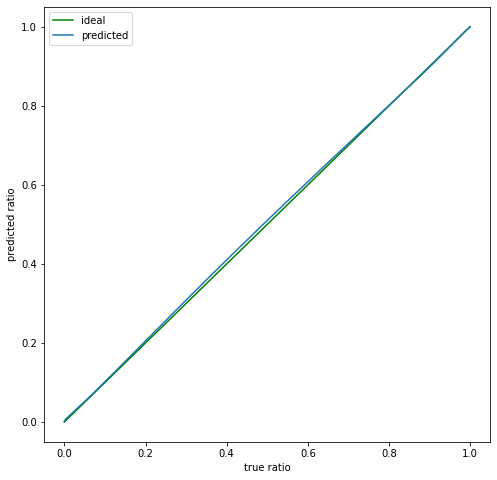

In [29]:
sorted_idx = torch.argsort(torch.stack(ratios))

fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.plot([0,1], [0,1], c='g', label='ideal')
ax.plot(torch.stack(ratios).numpy()[sorted_idx], predicted_ratio.detach().numpy()[sorted_idx], label='predicted')
ax.legend()
plt.xlabel('true ratio'); plt.ylabel('predicted ratio'); plt.show()

We can also look at the ratios for each data point

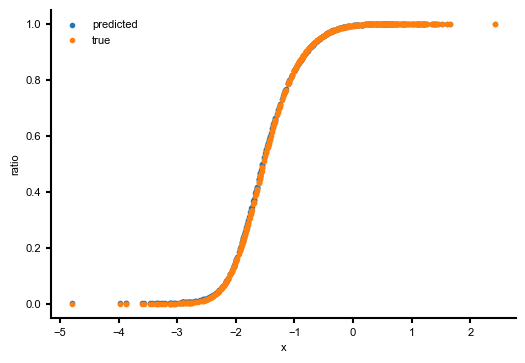

In [21]:
n_samples = 500
with mpl.rc_context(fname="loss_calibration/.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.scatter(x_test[:n_samples].numpy(), predicted_ratio[:n_samples].detach().numpy(), label='predicted')
    ax.scatter(x_test[:n_samples], ratios[:n_samples], label='true')
    ax.legend()
    plt.xlabel('x'); plt.ylabel('ratio'); plt.show()

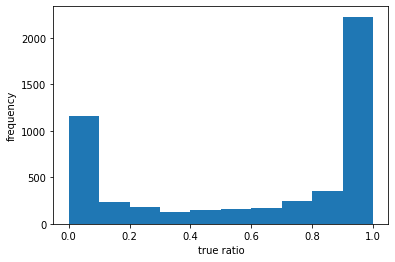

In [36]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.hist(torch.stack(ratios).numpy())
ax.set_xlabel('true ratio'), ax.set_ylabel('frequency')
plt.show()

From the histogram it become apparent that most of the ratios are easy to decide, much less observations lead to ratios that are difficult to decide about. 